# Load modules

In [1]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial

from timeit import default_timer
import scipy.io
import math
import gc
import glob

import h5py

# Load data (will take a while) and process

In [2]:
hf_r = h5py.File(f'/oak/stanford/schools/ees/smbenson/andchu/shale_clean.hdf5', 'r')
data_x_shale = np.array(hf_r.get('x'))
data_SG_shale = np.array(hf_r.get('SG'))
data_P_shale = np.array(hf_r.get('P'))
data_P_init_shale = np.array(hf_r.get('P_init'))
hf_r.close()
print('Checkpoint 1')

Checkpoint 1


In [ ]:
# GAS SATURATION DATA -------------------------------------------------
# Z SCORE NORMALIZATION
SG_mean = np.mean(data_SG_shale)
SG_std = np.std(data_SG_shale)
print(SG_mean)
print(SG_std)
    
data_SG_shale = (data_SG_shale - SG_mean)/(SG_std)

data_x = np.concatenate([data_x_shale], axis=0)
data_sg = np.concatenate([data_SG_shale], axis=0)

data_nr = data_x.shape[0]
test_nr = 600
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

data_x = data_x[shuffle_index, ...]
data_sg = data_sg[shuffle_index, ...]

print('Checkpoint 2')

idx = [0,6,12,18,19,20,21,22,23]
data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x_fit[:,j,:,:] = data_x[:,index,:,:]
    
print('Checkpoint 3')
    
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

x_in = data_x_fit.transpose((0,2,3,1))
SG = data_sg.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
SG = SG.astype(np.float32)

x_in = torch.from_numpy(x_in)
SG = torch.from_numpy(SG)

print('Checkpoint 4')

# a input u output
train_a = x_in[:train_nr,:,:,:]
train_u = SG[:train_nr,:,:,:]

test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
test_u = SG[train_nr:train_nr+ test_nr,:,:,:]

T = 24

train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
    train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
train_a_SG = train_a
test_a_SG = test_a
train_u_SG = train_u
test_u_SG = test_u
    
print('Checkpoint 6')

0.019367479650039064
0.10341674964334545


In [4]:
# PRESSURE BUILDUP ---------------------------------------------------
data_dP_shale = data_P_shale - data_P_init_shale

# Z-Score Normalization
dP_mean = np.mean(data_dP_shale)
dP_std = np.std(data_dP_shale)
print(dP_mean)
print(dP_std)

data_dP_shale = (data_dP_shale - dP_mean)/(dP_std)

data_x = np.concatenate([data_x_shale], axis=0)
data_dP = np.concatenate([data_dP_shale], axis=0)

data_nr = data_x.shape[0]
test_nr = 100
train_nr = data_nr - test_nr

np.random.seed(0)
shuffle_index = np.random.choice(data_nr, data_nr, replace=False)

data_x = data_x[shuffle_index, ...]
data_dP = data_dP[shuffle_index, ...]

print('Checkpoint 2')

idx = [0,6,12,18,19,20,21,22,23]
data_x_fit = np.zeros((data_x.shape[0], len(idx)+3, 96, 200))
for j, index in enumerate(idx):
    data_x_fit[:,j,:,:] = data_x[:,index,:,:]

print('Checkpoint 3')
    
dz = 2.083330
dx = [0.1]

with open('DRV.txt') as f:
    for line in f:
        line = line.strip().split('*')
        dx.append(float(line[-1]))
dx = np.cumsum(dx)
grid_x = dx/np.max(dx)
grid_x = grid_x[1:]
grid_y = np.linspace(0, 200, 96)/np.max(dx)

data_x_fit[:,-3,:,:] = grid_x[np.newaxis, np.newaxis, :]
data_x_fit[:,-2,:,:] = grid_y[np.newaxis, :, np.newaxis]
data_x_fit[:,-1,:,:] = np.ones(data_x_fit[:,-1,:,:].shape)

data_x_fit[:,-3,:,:] = data_x_fit[:,-3,:,:]/np.max(data_x_fit[:,-3,:,:])
data_x_fit[:,-2,:,:] = data_x_fit[:,-2,:,:]/np.max(data_x_fit[:,-2,:,:])

x_in = data_x_fit.transpose((0,2,3,1))
dP = data_dP.transpose((0,2,3,1))

x_in = x_in.astype(np.float32)
dP = dP.astype(np.float32)

x_in = torch.from_numpy(x_in)
dP = torch.from_numpy(dP)

print('Checkpoint 4')

# [3616, 96, 200, 12] = [num reservoirs, vertical length, lateral length, 12 parameters]
# [3616, 96, 200, 12] = [..., ..., ..., 24 time steps for prediction]

# a input u output
train_a = x_in[:train_nr,:,:,:]
train_u = dP[:train_nr,:,:,:]

test_a = x_in[train_nr:train_nr+ test_nr,:,:,:]
test_u = dP[train_nr:train_nr+ test_nr,:,:,:]

T = 24

train_a = train_a[:,:,:,np.newaxis,:]
test_a = test_a[:,:,:,np.newaxis,:]

train_a = train_a.repeat([1,1,1,T,1])
test_a = test_a.repeat([1,1,1,T,1])

print('Checkpoint 5')

t = np.cumsum(np.power(1.421245, range(24)))
t /= np.max(t)
for i in range(24):
    train_a[:,:,:,i,-1] = t[i]
    test_a[:,:,:,i,-1] = t[i]
    
train_a_dP = train_a
test_a_dP = test_a
train_u_dP = train_u
test_u_dP = test_u

print('Checkpoint 6')

1.1323901246254815
9.17773280445466
Checkpoint 2
Checkpoint 3
Checkpoint 4
Checkpoint 5
Checkpoint 6


# Initialize helper function for plotting

In [5]:
def plotMasked(position, x_in, X, Y, data, cbarlim):
    mask = x_in != 0
    thickness = sum(mask[:,0])
    axsObj = fig.add_axes(position)
    myplot = axsObj.pcolor(X[:thickness, :200], Y[:thickness, :200], 
                           np.flipud(data[mask].reshape((thickness, -1))), 
                           shading='auto')
    axsObj.set_xlim(0, 5000)
    #axsObj.set_aspect(10)
    
    axsObj.set_position(position)
    
    if position[1] > 0.5: # top row
        position[0] = position[0] + 0.05
    else: # bottom row
        position[0] = position[0] + 0.08
        
    cbaraxes = fig.add_axes(position)
    cbaraxes.set_axis_off()
    cbar = fig.colorbar(myplot, ax=cbaraxes)
    if cbarlim != None:
        myplot.set_clim(cbarlim)
    
    return axsObj

# Plot figure

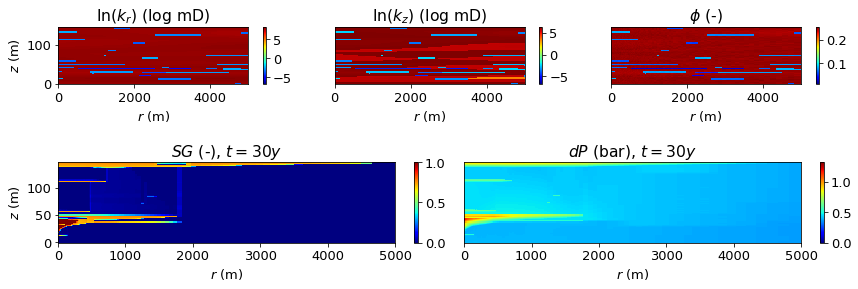

In [6]:
n = 475
    
fig = plt.figure(figsize=(12, 4))
plt.rcParams.update({'font.size':13})

plt.jet()
x = train_a_SG[n, :, :, 0, 0]
dx = np.cumsum(3.5938*np.power(1.035012, range(200))) + 0.1
X, Y = np.meshgrid(dx, np.linspace(0,200,num = 96))

# POSITIONING
# x_start, y_start, x_length, y_length. relative to bottom left corner. units are size of entire figure
wspace_top = 0.32
wspace_bot = 0.47
figlen_top = 0.22
figlen_bot = 0.39
fighei_top = 0.20
fighei_bot = 0.28
pos0 = [None] * 3 # initialize array containing None x3
pos1 = [None] * 2
pos0[0] = [0.07, 0.7, figlen_top, fighei_top]
pos0[1] = [0.07 + wspace_top, 0.7, figlen_top, fighei_top]
pos0[2] = [0.07 + 2*wspace_top, 0.7, figlen_top, fighei_top]
pos1[0] = [0.07, 0.15, figlen_bot, fighei_bot]
pos1[1] = [0.07 + wspace_bot, 0.15, figlen_bot, fighei_bot]

# TOP ROW OF PLOTS

axs00 = plotMasked(pos0[0], x, X, Y, np.log(np.exp(train_a_SG[n, :, :, 0, 0]*15)), None)
axs00.set_title("ln($k_r$) (log mD)")
axs00.set_xlabel("$r$ (m)")
axs00.set_ylabel("$z$ (m)")

axs01 = plotMasked(pos0[1], x, X, Y, np.log(np.exp(train_a_SG[n, :, :, 0, 1]*15)), None)
axs01.set_title("ln($k_z$) (log mD)")
axs01.set_xlabel("$r$ (m)")
axs01.set_yticks([])

axs02 = plotMasked(pos0[2], x, X, Y, train_a_SG[n, :, :, 0, 2], None)
axs02.set_title("$\phi$ (-)")
axs02.set_xlabel("$r$ (m)")
axs02.set_yticks([])

# BOTTOM ROW OF PLOTS

axs10 = plotMasked(pos1[0], x, X, Y, train_u_SG[n, :, :, -1] * SG_std + SG_mean, [0, 1])
axs10.set_title("$SG$ (-), $t = 30y$")
axs10.set_xlabel("$r$ (m)")
axs10.set_ylabel("$z$ (m)")

cmax = torch.max(train_u_dP[n, :, :, -1] * dP_std + dP_mean).item()
axs11 = plotMasked(pos1[1], x, X, Y, train_u_dP[n, :, :, -1] * dP_std + dP_mean, [0, cmax])
axs11.set_title("$dP$ (bar), $t = 30y$")
axs11.set_xlabel("$r$ (m)")
axs11.set_yticks([])

# fig.savefig('_paper_datasetExample.png', dpi=300)
fig.show()